In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras import layers 
from keras.models import Sequential
import keras.optimizers
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import LeakyReLU
import random


In [4]:

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def create_model(act1, act2, train_input_shape):
    # Define your model architecture here
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape= train_input_shape),
        tf.keras.layers.Dense(6, activation=act1),
        tf.keras.layers.Dense(32, activation=act1),
        tf.keras.layers.Dense(64, activation=act1),
        tf.keras.layers.Dense(128, activation=act1),
        tf.keras.layers.Dense(1, activation=act2)])
    
    return model

colnames = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'var1', 'var2', 'var3']
df = pd.read_csv("train_cf_onlyFTOF.csv", usecols=[i for i in range(9)], names = colnames, skiprows=0, sep=",", header=None, skip_blank_lines=True)
df = df.sample(frac=1).reset_index(drop=True)
df.drop(df.columns[[7,8]], axis=1, inplace=True)
print(df.head(5))
train_frac = 0.7

train_arr = df.iloc[:int(train_frac*len(df)), 0:]
test_arr = df.iloc[int(train_frac*len(df)):, 0:]

# Fix this to fit different shapes of df.
train_x = train_arr.iloc[:, :-1] 
train_y = train_arr.iloc[:, -1:]


test_x = test_arr.iloc[:, :-1] 
test_y = test_arr.iloc[:, -1:]
print(test_y.head(5))
print(test_x.head(5))
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y))

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(1)
#tf.data.experimental.AUTOTUNE: I don't know what this does.
train_input_shape = train_x[0].shape



     layer1    layer2    layer3    layer4    layer5    layer6      var1
0  0.248512  0.254464  0.223214  0.220238  0.187500  0.181548  0.241935
1  0.302679  0.275000  0.270408  0.236607  0.213010  0.185714  0.258065
2  0.625000  0.589286  0.574405  0.525298  0.468750  0.425595  0.532258
3  0.422619  0.414286  0.308036  0.298469  0.031888  0.022557  0.258065
4  0.462798  0.456827  0.419643  0.406250  0.342262  0.328571  0.403226
           var1
70000  0.177419
70001  0.096774
70002  0.112903
70003  0.112903
70004  0.483871
         layer1    layer2    layer3    layer4    layer5    layer6
70000  0.272321  0.262755  0.238095  0.218112  0.168155  0.148810
70001  0.151786  0.146684  0.130102  0.114583  0.087798  0.071429
70002  0.184524  0.180357  0.162202  0.147817  0.112723  0.098214
70003  0.140306  0.157738  0.121173  0.127976  0.085459  0.085714
70004  0.562500  0.581845  0.505357  0.511905  0.410714  0.407738


2024-09-09 19:03:08.628613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
activations1 = ['relu', LeakyReLU(alpha=0.01), 'tanh']
activations2 = ['linear']

activation_results = {}
for act1 in activations1:
    # Initialize the dictionary for act1 if it doesn't exist
    if act1 not in activation_results:
        activation_results[act1] = {}


for act1 in activations1:
    for act2 in activations2:
        # Get a new model with the current activation
        model = create_model(act1, act2, train_input_shape)
        # Fit the model and store the history results
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error"), metrics=['mse', 'mae'])
        h_callback = model.fit(train_dataset, epochs=75, validation_data=test_dataset)
        activation_results[act1][act2] = {
            'history': h_callback.history,
            'loss': h_callback.history['loss'],  # Training loss
            'val_loss': h_callback.history['val_loss'],  # Validation loss
            'predictions': model.predict(test_x)
        }

for act1 in activations1:
    for act2 in activations2:
        print(f"Results for act1 = {act1}, act2 = {act2}:")
        print("Training loss:", activation_results[act1][act2]['loss'])
        print("Validation loss:", activation_results[act1][act2]['val_loss'])



Epoch 1/75
1094/1094 [==============================] - 14s 12ms/step - loss: 8.9473e-04 - mse: 8.9473e-04 - mae: 0.0126 - val_loss: 1.8452e-04 - val_mse: 1.8452e-04 - val_mae: 0.0060
Epoch 2/75
1094/1094 [==============================] - 13s 12ms/step - loss: 2.1574e-04 - mse: 2.1574e-04 - mae: 0.0072 - val_loss: 1.7416e-04 - val_mse: 1.7416e-04 - val_mae: 0.0058
Epoch 3/75
1094/1094 [==============================] - 13s 12ms/step - loss: 2.0963e-04 - mse: 2.0963e-04 - mae: 0.0070 - val_loss: 1.7212e-04 - val_mse: 1.7212e-04 - val_mae: 0.0059
Epoch 4/75
1094/1094 [==============================] - 13s 12ms/step - loss: 2.0646e-04 - mse: 2.0646e-04 - mae: 0.0070 - val_loss: 1.6345e-04 - val_mse: 1.6345e-04 - val_mae: 0.0056
Epoch 5/75
1094/1094 [==============================] - 13s 12ms/step - loss: 2.0218e-04 - mse: 2.0218e-04 - mae: 0.0069 - val_loss: 1.5673e-04 - val_mse: 1.5673e-04 - val_mae: 0.0055
Epoch 6/75
1094/1094 [==============================] - 13s 12ms/step - loss: 1.

In [8]:

# Prepare a list to hold the results
results_list = []

# Iterate through the activation_results dictionary
for act1 in activation_results:
    for act2 in activation_results[act1]:
        # Extract loss values
        loss = activation_results[act1][act2]['loss']
        val_loss = activation_results[act1][act2]['val_loss']
        predictions = activation_results[act1][act2]['predictions']
        # Calculate mean loss
        mean_training_loss = sum(loss) / len(loss)
        mean_validation_loss = sum(val_loss) / len(val_loss)
        # Create a dictionary for each epoch
        for epoch in range(len(loss)):
            result_dict = {
                'Activation 1': act1,
                'Activation 2': act2,
                'Epoch': epoch + 1,
                'Training Loss': loss[epoch],
                'Validation Loss': val_loss[epoch],
                'Mean Training Loss': mean_training_loss,
                'Mean Validation Loss': mean_validation_loss,
                'Predictions': predictions
            }
           
            # Append the dictionary to the results list
            results_list.append(result_dict)



    Activation 1 Activation 2  Epoch  Training Loss  Validation Loss  \
0           relu       linear      1       0.000895         0.000185   
1           relu       linear      2       0.000216         0.000174   
2           relu       linear      3       0.000210         0.000172   
3           relu       linear      4       0.000206         0.000163   
4           relu       linear      5       0.000202         0.000157   
..           ...          ...    ...            ...              ...   
220         tanh       linear     71       0.000217         0.000205   
221         tanh       linear     72       0.000217         0.000205   
222         tanh       linear     73       0.000216         0.000205   
223         tanh       linear     74       0.000216         0.000205   
224         tanh       linear     75       0.000216         0.000204   

     Mean Training Loss  Mean Validation Loss  \
0              0.000194              0.000159   
1              0.000194              

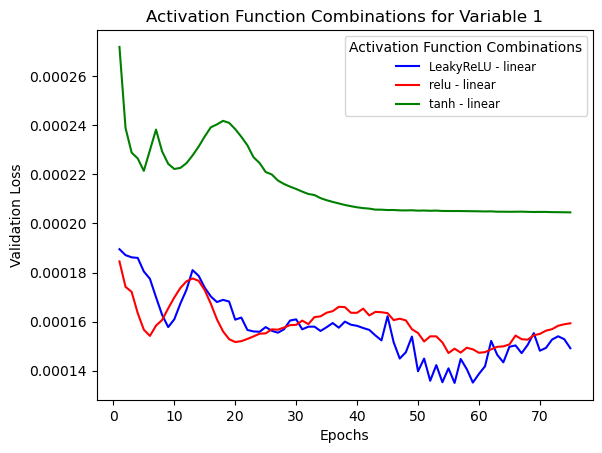

In [9]:
def get_activation_name(activation):
    if callable(activation):  # Check if it's a function or a callable object
        return activation.__name__ if hasattr(activation, '__name__') else activation.__class__.__name__
    return str(activation)  # Handle string names like 'linear', 'sigmoid'

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)
# Convert non-string types (e.g., functions or objects) to strings for concatenation
results_df['Activation 1 string'] = results_df['Activation 1'].apply(get_activation_name)

results_df['combined_label'] = results_df['Activation 1 string'].astype(str) + ' - ' + results_df['Activation 2']
# Display the DataFrame
print(results_df)
# Manually define a list of colors (this list can be extended)
colors_list = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink', 'gray', 'olive']

# Get unique labels
unique_labels = results_df['combined_label'].unique()

# Create a color mapping: each label gets a color from the list
color_dict = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Initialize the plot
fig, ax = plt.subplots()

# Plot each group with its corresponding color
for label, group in results_df.groupby('combined_label'):
    ax.plot(group['Epoch'], group['Validation Loss'], linestyle='-', label=label, color=color_dict[label])

# Add legend
ax.legend(title="Activation Function Combinations", fontsize='small', loc='upper right', bbox_to_anchor=(1, 1))
plt.title("Activation Function Combinations for Variable 1")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
# Show plot
plt.show()